In [1]:
import do_mpc
import numpy as np
import casadi as ca

%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import art3d

In [2]:
# Parameters

# obstacle
x_obs = 0.5*np.ones(3)
r_obs = 0.1
# timestep
dt = 0.1

In [3]:
model_type = 'discrete' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

In [4]:
# position (x, y, z)
x = model.set_variable(var_type='_x', var_name='x', shape=(3,1))
# velocity (dx, dy, dz)
dx = model.set_variable(var_type='_x', var_name='dx', shape=(3,1))
# controls (u1, u2, u3)
u = model.set_variable(var_type='_u', var_name='u', shape=(3,1))
# obstacle postion
x_obs_p = model.set_variable(var_type='_p', var_name='x_obs_p', shape=(3,1))

#d_obs_p = -( (x[0] - x_obs_p[0])**2 + (x[1] - x_obs_p[1])**2 + (x[2] - x_obs_p[2])**2 )#expr=-( (x[0] - x_obs_p[0])**2 + (x[1] - x_obs_p[1])**2 + (x[2] - x_obs_p[2])**2 ))

In [5]:
# system dynamics
model.set_rhs('x', x + dx * dt)
model.set_rhs('dx', u)

# setup model
model.setup()

# init mpc model
mpc = do_mpc.controller.MPC(model)

setup_mpc = {
    'n_horizon': 20,
    't_step': dt,
    'store_full_solution': True,
}

mpc.set_param(**setup_mpc)
mpc.settings.supress_ipopt_output()

In [6]:
# set objective fuction

x_d = np.array([1., 1., 1.]) # desired position
# stage and terminal cost
mterm = (x[0] - x_d[0])**2 + (x[1] - x_d[1])**2 + (x[2] - x_d[2])**2
lterm = mterm
# state objective
mpc.set_objective(mterm=mterm, lterm=lterm)
# input objective
mpc.set_rterm(u=1.)

In [7]:
# constraints
mpc.bounds['upper','_u', 'u'] = 0.5 * np.ones((3, 1))   # input upper bound
mpc.bounds['lower','_u', 'u'] = -0.5 * np.ones((3, 1))  # input lower bound

# collision avoidance constraint
#d_obs = -( (x[0] - x_obs_p[0])**2 + (x[1] - x_obs_p[1])**2 + (x[2] - x_obs_p[2])**2 )
d_obs = -ca.norm_2(x - x_obs_p)**2
mpc.set_nl_cons('d_obs', expr=d_obs, ub=-0.01, soft_constraint=True, penalty_term_cons=1e6)

SX((-((sq((x_0-x_obs_p_0))+sq((x_1-x_obs_p_1)))+sq((x_2-x_obs_p_2)))))

In [8]:
# set parameter values
mpc.set_uncertainty_values(
  x_obs_p = x_obs
)

In [9]:
# setup MPC problem
mpc.setup()

In [10]:
# initialize MPC problem
x0 = np.zeros((6,))
mpc.x0 = x0
# compute initial guess (important)
mpc.set_initial_guess()

In [11]:
# solve mpc at state x0
u0 = mpc.make_step(x0)

In [12]:
# retrieve state trajectory
x_scp = []
for i in range(len(mpc.opt_x_num['_x', :, 0, 0])):
  x_scp.append(mpc.opt_x_num['_x', :, 0, 0][i].toarray()[:3].squeeze())

x_scp = np.array(x_scp)

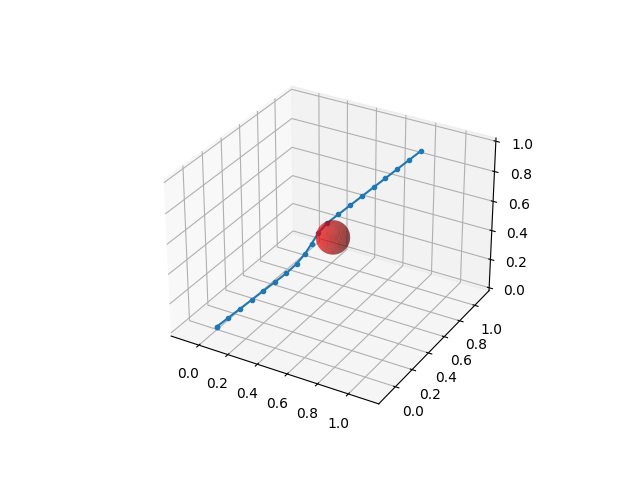

In [13]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.axis('equal')
# Plot the trajectory
ax.plot(x_scp[:,0], x_scp[:,1], x_scp[:,2], '.-')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 50)
x_sphere = x_obs[0] + r_obs * np.outer(np.cos(u), np.sin(v))
y_sphere = x_obs[1] + r_obs * np.outer(np.sin(u), np.sin(v))
z_sphere = x_obs[2] + r_obs * np.outer(np.ones(np.size(u)), np.cos(v))
sphere = ax.plot_surface(x_sphere, y_sphere, z_sphere, color='r', alpha=0.5)